In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import Union, Optional, Dict, Tuple, Any

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score

In [7]:
diabetes = pd.read_csv('../datasets/diabetes_prediction/train.csv').dropna(how='all')
diabetes 

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,699995,29,1,59,6.9,5.2,1.5,26.1,0.88,133,...,Female,Hispanic,Postgraduate,Upper-Middle,Former,Employed,0,0,0,0.0
699996,699996,46,2,72,7.7,7.7,3.8,25.5,0.85,106,...,Female,Hispanic,Graduate,Upper-Middle,Former,Employed,0,0,1,1.0
699997,699997,35,1,50,5.6,6.1,6.4,26.9,0.88,127,...,Female,White,Graduate,Middle,Never,Employed,0,0,0,1.0
699998,699998,49,2,70,5.7,6.9,4.7,25.2,0.86,116,...,Female,White,Highschool,Lower-Middle,Never,Retired,0,0,0,1.0


In [3]:
diabetes.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [4]:
diabetes['ethnicity'].value_counts()

ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64

In [5]:
diabetes['education_level'].value_counts()

education_level
Highschool      344145
Graduate        261268
Postgraduate     79642
No formal        14945
Name: count, dtype: int64

In [6]:
diabetes['income_level'].value_counts()

income_level
Middle          290557
Lower-Middle    178570
Upper-Middle    127836
Low              85803
High             17234
Name: count, dtype: int64

In [7]:
diabetes['smoking_status'].value_counts()

smoking_status
Never      494448
Current    103363
Former     102189
Name: count, dtype: int64

In [8]:
diabetes['employment_status'].value_counts()

employment_status
Employed      516170
Retired       115735
Unemployed     49787
Student        18308
Name: count, dtype: int64

In [9]:
diabetes['alcohol_consumption_per_week'].value_counts()

alcohol_consumption_per_week
2    246592
1    246311
3    137565
4     52973
5     13322
6      2728
7       447
8        59
9         3
Name: count, dtype: int64

In [10]:
diabetes['physical_activity_minutes_per_week'].value_counts()

physical_activity_minutes_per_week
63     10658
39     10005
52      9954
59      9943
36      9741
       ...  
536        1
631        1
541        1
602        1
647        1
Name: count, Length: 565, dtype: int64

In [11]:
diabetes['gender'].value_counts()

gender
Female    363237
Male      333085
Other       3678
Name: count, dtype: int64

In [8]:
def preprocess(
    data: pd.DataFrame
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    data = data.copy()
    data_info: Dict[str, Any] = {}

    if 'id' in data.columns:
        data.drop('id', axis=1, inplace=True)

    gender_map = {'Male': 1, 'Female': 0, 'Other': 0}
    data['gender'] = data['gender'].map(gender_map).astype('int8')
    data_info['gender_map'] = gender_map

    data = pd.get_dummies(data, columns=['ethnicity', 'employment_status', 'smoking_status'], dtype='int8')
    data_info['ethnicity_dummies'] = [c for c in data.columns if c.startswith("ethnicity_")]
    data_info['employment_status_dummies'] = [c for c in data.columns if c.startswith("employment_status_")]
    data_info['smoking_status_dummies'] = [c for c in data.columns if c.startswith("smoking_status_")]

    data['alcohol_consumption_per_week'] = np.where(
        data['alcohol_consumption_per_week'] >= 6, 
        6, 
        data['alcohol_consumption_per_week']
    ).astype('int8')
    alcohol_levels = sorted(data['alcohol_consumption_per_week'].unique())
    data_info['alcohol_levels'] = alcohol_levels

    income_map = {
        "Low": 1,
        "Lower-Middle": 2,
        "Middle": 3,
        "Upper-Middle": 4,
        "High": 5
    }
    data['income_level'] = data['income_level'].map(income_map).astype('int8')
    data_info['income_map'] = income_map

    education_map = {
        'No formal': 0,
        'Highschool': 1,
        'Graduate': 2,
        'Postgraduate': 3
    }
    data['education_level'] = data['education_level'].map(education_map).astype('int8')
    data_info['education_map'] = education_map

    eps = 1e-3
    data['physical_activity_minutes_per_week'] = np.log(data['physical_activity_minutes_per_week'] + eps)
    scaler_pa = StandardScaler()
    data[['physical_activity_minutes_per_week']] = scaler_pa.fit_transform(data[['physical_activity_minutes_per_week']]).astype('float32')
    data_info['scaler_physical_activity'] = scaler_pa

    for col in ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']:
        data[col] = data[col].astype('int8')

    scale_cols = [
        'age', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day',
        'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp',
        'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 
        'ldl_cholesterol', 'triglycerides'
    ]
    scalers = {}
    for col in scale_cols:
        scaler = StandardScaler()
        data[[col]] = scaler.fit_transform(data[[col]]).astype('float32')
        scalers[col] = scaler
    data_info['scale_cols'] = scale_cols
    data_info['scalers'] = scalers

    dtype_map = {}
    for col, dtype in data.dtypes.items():
        if dtype == np.int64:
            data[col] = data[col].astype('int32')
            dtype_map[col] = 'int32'
        elif dtype == np.float64:
            data[col] = data[col].astype('float32')
            dtype_map[col] = 'float32'
        elif dtype == np.int32 or dtype == np.int16:
            data[col] = data[col].astype('int16')
            dtype_map[col] = 'int16'
        elif dtype == np.int8:
            dtype_map[col] = 'int8'
        elif dtype == np.float32:
            dtype_map[col] = 'float32'
        else:
            dtype_map[col] = str(dtype)
    data_info['dtype_map'] = dtype_map

    data_info['data_columns'] = data.columns.tolist()

    return data, data_info

In [9]:
y = diabetes['diagnosed_diabetes'].astype('int8')
x = diabetes.drop('diagnosed_diabetes', axis=1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [11]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((525000, 25), (175000, 25), (525000,), (175000,))

In [12]:
x_train_p, data_info = preprocess(x_train)

In [13]:
x_train_p

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Current,smoking_status_Former,smoking_status_Never
664782,-0.031789,2,-1.160617,0.366811,0.108773,2.118982,-2.821725,-2.338565,-1.025064,0.666955,...,0,0,1,1,0,0,0,0,0,1
136118,-0.889895,2,-1.815898,-0.043106,-0.002071,-0.647897,1.127553,0.823006,-0.207999,1.106388,...,0,0,0,0,1,0,0,0,0,1
512730,-0.375031,2,-0.303551,-0.384704,0.995522,0.439091,0.393616,1.086470,-0.207999,-0.797820,...,0,0,1,0,0,1,0,1,0,0
617630,-0.718274,1,1.047393,-0.862940,-1.110507,-1.339617,-0.410219,0.296078,-0.934279,-1.530208,...,0,0,1,1,0,0,0,0,0,1
206464,0.740507,3,0.486027,-0.453023,2.436489,0.439091,0.044123,-0.494315,0.518281,1.399343,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,-0.460842,2,-0.534686,-2.092692,-1.221351,0.686134,2.315832,2.403792,-0.298784,0.666955,...,1,0,0,1,0,0,0,0,0,1
152315,-0.546653,1,0.034394,0.025214,-0.445446,-1.833703,0.393616,-0.230851,-0.207999,-1.823163,...,1,0,0,1,0,0,0,0,0,1
117952,-1.061517,1,1.691292,1.050007,0.330460,-0.549080,-2.157687,-1.811636,0.518281,0.081045,...,0,0,1,1,0,0,0,0,0,1
435829,1.341182,3,-1.160617,1.459924,1.549740,-0.944349,0.568363,0.823006,0.609066,0.520478,...,0,0,0,1,0,0,0,1,0,0


In [14]:
x_train_p.to_csv('diabetes_x_train_p.csv', index=False)

In [15]:
data_info

{'gender_map': {'Male': 1, 'Female': 0, 'Other': 0},
 'ethnicity_dummies': ['ethnicity_Asian',
  'ethnicity_Black',
  'ethnicity_Hispanic',
  'ethnicity_Other',
  'ethnicity_White'],
 'employment_status_dummies': ['employment_status_Employed',
  'employment_status_Retired',
  'employment_status_Student',
  'employment_status_Unemployed'],
 'smoking_status_dummies': ['smoking_status_Current',
  'smoking_status_Former',
  'smoking_status_Never'],
 'alcohol_levels': [np.int8(1),
  np.int8(2),
  np.int8(3),
  np.int8(4),
  np.int8(5),
  np.int8(6)],
 'income_map': {'Low': 1,
  'Lower-Middle': 2,
  'Middle': 3,
  'Upper-Middle': 4,
  'High': 5},
 'education_map': {'No formal': 0,
  'Highschool': 1,
  'Graduate': 2,
  'Postgraduate': 3},
 'scaler_physical_activity': StandardScaler(),
 'scale_cols': ['age',
  'diet_score',
  'sleep_hours_per_day',
  'screen_time_hours_per_day',
  'bmi',
  'waist_to_hip_ratio',
  'systolic_bp',
  'diastolic_bp',
  'heart_rate',
  'cholesterol_total',
  'hdl_ch

In [16]:
def preprocess_test(data: pd.DataFrame, data_info: Dict[str, Any]) -> pd.DataFrame:
    data = data.copy()

    if 'id' in data.columns:
        data.drop('id', axis=1, inplace=True)

    gender_map = data_info['gender_map']
    data['gender'] = data['gender'].map(gender_map).astype('int8')

    data = pd.get_dummies(data, columns=['ethnicity', 'employment_status', 'smoking_status'], dtype='int8')
    for col in data_info['ethnicity_dummies']:
        if col not in data.columns:
            data[col] = 0
    for col in data_info['employment_status_dummies']:
        if col not in data.columns:
            data[col] = 0
    for col in data_info['smoking_status_dummies']:
        if col not in data.columns:
            data[col] = 0

    data['alcohol_consumption_per_week'] = np.where(
        data['alcohol_consumption_per_week'] >= 6, 
        6, 
        data['alcohol_consumption_per_week']
    ).astype('int8')

    income_map = data_info['income_map']
    data['income_level'] = data['income_level'].map(income_map).astype('int8')

    education_map = data_info['education_map']
    data['education_level'] = data['education_level'].map(education_map).astype('int8')

    eps = 1e-3
    data['physical_activity_minutes_per_week'] = np.log(data['physical_activity_minutes_per_week'] + eps)
    scaler_pa = data_info['scaler_physical_activity']
    data[['physical_activity_minutes_per_week']] = scaler_pa.transform(data[['physical_activity_minutes_per_week']]).astype('float32')

    for col in ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']:
        data[col] = data[col].astype('int8')
    
    scale_cols = data_info['scale_cols']
    scalers = data_info['scalers']
    for col in scale_cols:
        scaler = scalers[col]
        data[[col]] = scaler.transform(data[[col]]).astype('float32')

    data = data.reindex(columns=data_info['data_columns'], fill_value=0)

    dtype_map = data_info['dtype_map']
    for col, dtype in dtype_map.items():
        if col in data.columns:
            data[col] = data[col].astype(dtype)

    return data

In [17]:
x_test_p = preprocess_test(x_test, data_info)

In [18]:
x_test_p

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Current,smoking_status_Former,smoking_status_Never
628789,0.139832,2,-0.431968,-1.136219,0.441304,-0.351446,1.197452,0.032613,0.155141,1.106388,...,0,0,1,0,1,0,0,0,0,1
469697,-0.804085,2,-2.309068,0.298492,-0.112915,-0.203220,0.568363,0.823006,0.609066,-0.211910,...,0,0,0,1,0,0,0,1,0,0
243043,-0.375031,1,-1.429333,0.640089,0.773834,-0.203220,-0.130624,0.296078,-1.388204,0.666955,...,0,0,1,1,0,0,0,0,0,1
164069,0.912128,2,0.728490,0.571770,1.438896,0.290865,-2.157687,-2.075101,0.699851,-0.504865,...,0,0,0,1,0,0,0,0,0,1
663085,-0.804085,3,1.280042,0.298492,0.108773,-0.746715,0.393616,1.349935,-0.480354,-3.141460,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160331,1.941856,1,-0.681468,1.050007,0.219616,-0.944349,-1.388801,-1.021244,2.243197,1.692298,...,1,0,0,1,0,0,0,0,0,1
377134,-0.289221,2,-1.111379,-0.384704,0.108773,0.290865,0.079072,-0.494315,-0.480354,0.374000,...,0,0,1,0,1,0,0,0,0,1
587359,1.169560,1,0.505885,-1.067899,-1.110507,1.229628,1.442098,0.296078,0.064356,1.838776,...,1,0,0,1,0,0,0,0,1,0
593344,0.654696,2,-0.606579,0.161853,0.552147,0.043822,-1.214054,-0.757779,0.881422,0.666955,...,0,0,1,0,0,0,1,0,0,1


In [23]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=42, class_weight='balanced')
dt_model.fit(x_train_p, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

In [24]:
y_dt_predicted_train = dt_model.predict(x_train_p)
y_dt_predicted_train

array([1, 0, 1, ..., 0, 1, 0], shape=(525000,), dtype=int8)

In [25]:
np.array(y_train)

array([0, 1, 0, ..., 0, 1, 0], shape=(525000,), dtype=int8)

In [26]:
def show_classification_report(y_true, y_pred):
    print("        [ CLASSIFICATION REPORT ]")
    print(classification_report(y_true, y_pred))
    print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")

In [27]:
def classification_plots(model, x_test, y_test):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax)
    plt.title('ROC-AUC Curve')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [28]:
show_classification_report(y_train, y_dt_predicted_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.51      0.69      0.59    197611
           1       0.76      0.59      0.67    327389

    accuracy                           0.63    525000
   macro avg       0.64      0.64      0.63    525000
weighted avg       0.67      0.63      0.64    525000

Overall Accuracy: 0.6319


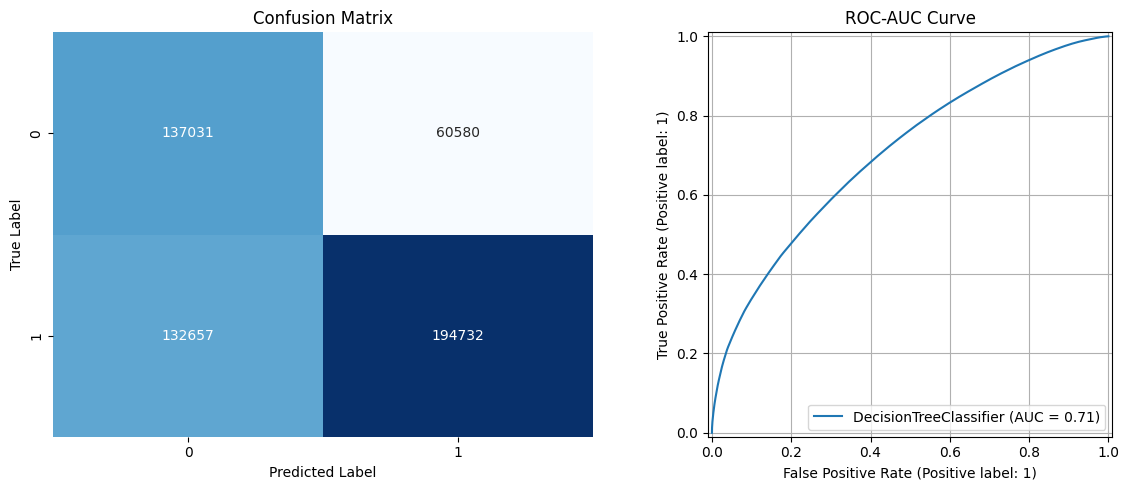

In [29]:
classification_plots(dt_model, x_train_p, y_train)

In [30]:
y_dt_predicted = dt_model.predict(x_test_p)
y_dt_predicted

array([1, 1, 1, ..., 1, 1, 0], shape=(175000,), dtype=int8)

In [31]:
np.array(y_test)

array([1, 1, 1, ..., 1, 1, 1], shape=(175000,), dtype=int8)

In [32]:
show_classification_report(y_test, y_dt_predicted)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.50      0.68      0.58     66082
           1       0.75      0.59      0.66    108918

    accuracy                           0.62    175000
   macro avg       0.63      0.63      0.62    175000
weighted avg       0.66      0.62      0.63    175000

Overall Accuracy: 0.6219


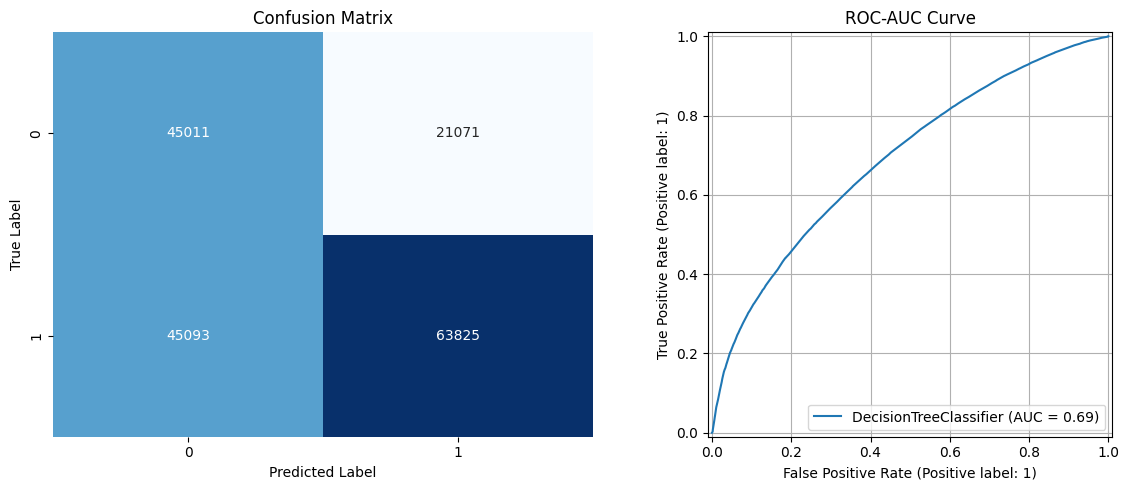

In [33]:
classification_plots(dt_model, x_test_p, y_test)

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(x_train_p, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [35]:
y_rf_predicted_train = rf_model.predict(x_train_p)
y_rf_predicted_train

array([1, 1, 1, ..., 0, 1, 1], shape=(525000,), dtype=int8)

In [36]:
show_classification_report(y_train, y_rf_predicted_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.65      0.27      0.38    197611
           1       0.67      0.91      0.78    327389

    accuracy                           0.67    525000
   macro avg       0.66      0.59      0.58    525000
weighted avg       0.66      0.67      0.63    525000

Overall Accuracy: 0.6702


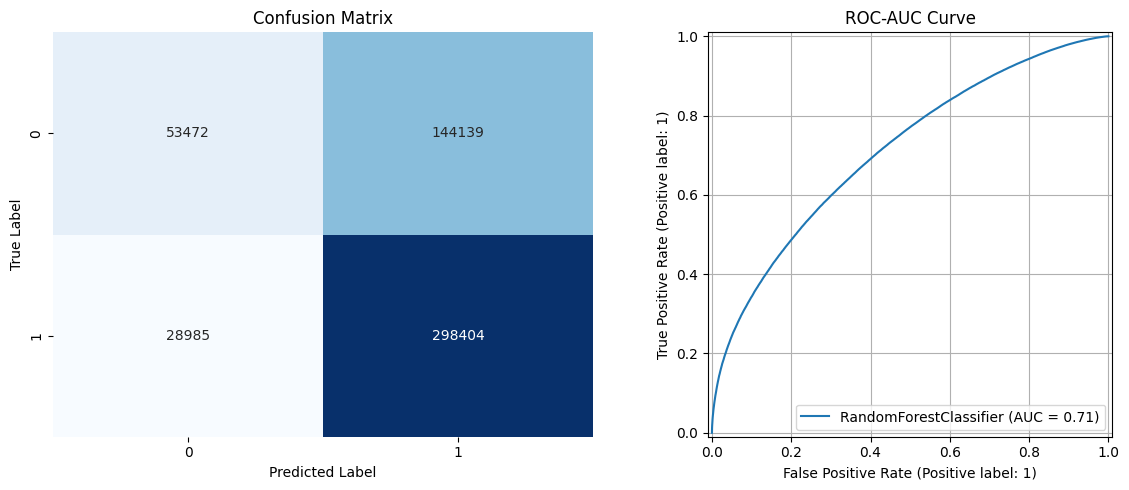

In [37]:
classification_plots(rf_model, x_train_p, y_train)

In [38]:
y_rf_predicted = rf_model.predict(x_test_p)
y_rf_predicted

array([1, 1, 1, ..., 1, 1, 1], shape=(175000,), dtype=int8)

In [39]:
show_classification_report(y_test, y_rf_predicted)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.63      0.26      0.37     66082
           1       0.67      0.91      0.77    108918

    accuracy                           0.66    175000
   macro avg       0.65      0.58      0.57    175000
weighted avg       0.65      0.66      0.62    175000

Overall Accuracy: 0.6622


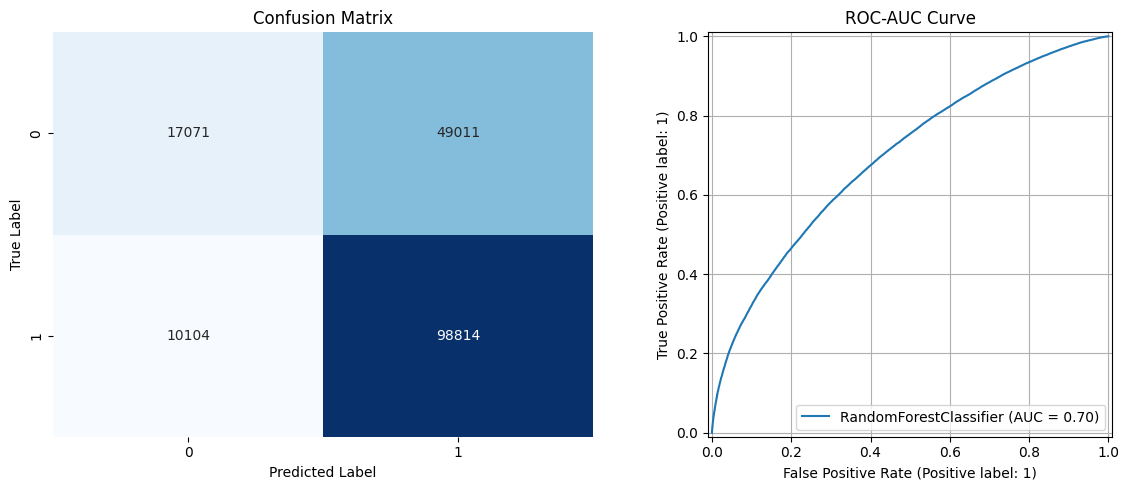

In [40]:
classification_plots(rf_model, x_test_p, y_test)

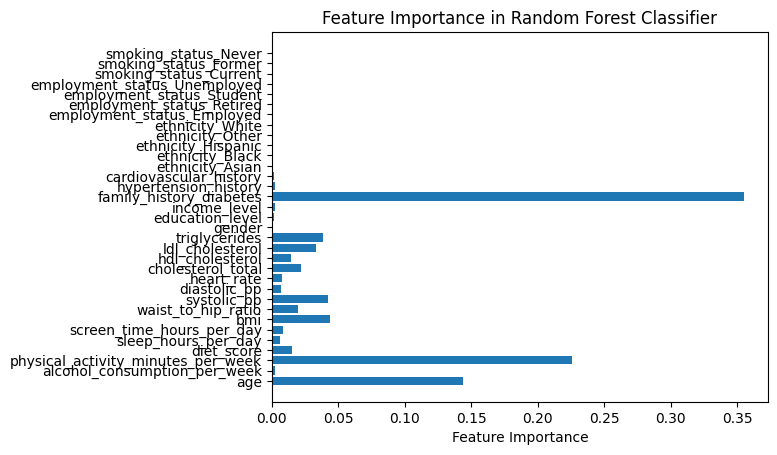

In [41]:
feature_importances = rf_model.feature_importances_

plt.barh(x_test_p.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [4]:
params = {
    "max_depth": [5, 8, 10, 15],
    "min_samples_leaf": [1, 5, 10, 30],
    "max_features": ["sqrt", "log2", None]
}

In [5]:
dt = DecisionTreeClassifier(random_state=42)

In [19]:
gs = GridSearchCV(dt, params, cv=3, scoring='roc_auc', n_jobs=-1)
gs.fit(x_train_p, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [5, 8, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 5, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displa

In [20]:
print("Best params:", gs.best_params_, "\nAUC:", gs.best_score_)

Best params: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 30} 
AUC: 0.6904068540157806
